In [1]:
# ln -s ../code/analytic.py analytic.py
%matplotlib inline

import numpy as np
import pandas as pd
import math

import thinkstats2
import thinkplot

import nsfg
import nsfg2
import first

import copy
import random
import matplotlib.pyplot as pyplot

## Least squares fit

Correlation coefficients measure the strength and sign of a realtionship but not the slope. The most common method to estimate the slope is a **linear least squares fit**.

In [2]:
def LeastSquares(xs,ys):
    meanx, varx = thinkstats2.MeanVar(xs)
    meany = Mean(ys)

    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope*meanx

    return inter, slope

def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

In [3]:
live, first, others = first.MakeFrames()
live = live.dropna(subset=['agepreg','totalwgt_lb'])
ages = live.agepreg
weights = live.totalwgt_lb

inter, slope = thinkstats2.LeastSquares(ages, weights)
fit_xs, fit_ys = thinkstats2.FitLine(ages, inter, slope)

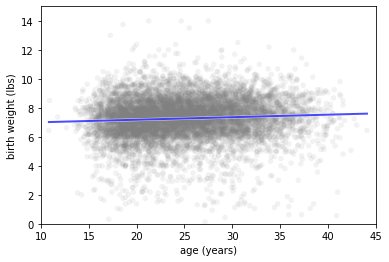

<Figure size 576x432 with 0 Axes>

In [4]:
thinkplot.Scatter(ages, weights, color='gray', alpha=0.1)
thinkplot.Plot(fit_xs, fit_ys, color='white', linewidth=3)
thinkplot.Plot(fit_xs, fit_ys, color='blue', linewidth=2)
thinkplot.Show(xlabel='age (years)', ylabel='birth weight (lbs)',
               axis = [10,45,0,15], legend = False)

In [5]:
def Residuals(xs, ys, inter, slope):
    xs = np.array(xs)
    ys = np.array(ys)
    res = ys - (inter + slope * xs)
    return res

In [6]:
ages = live.agepreg
weights = live.totalwgt_lb
inter,slope = thinkstats2.LeastSquares(ages,weights)
live['residual'] = thinkstats2.Residuals(ages, weights, inter, slope)

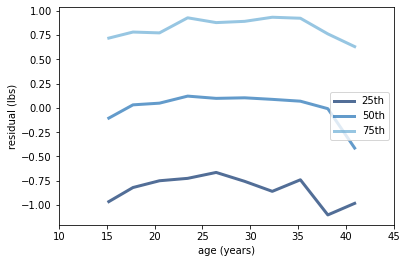

<Figure size 576x432 with 0 Axes>

In [7]:
bins = np.arange(10,48,3)
indices = np.digitize(live.agepreg, bins)
groups = live.groupby(indices)

ages = [group.agepreg.mean() for _, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.residual) for _, group in groups][1:-1]

thinkplot.PrePlot(3)
for percent in [25, 50, 75]:
    weights = [cdf.Percentile(percent) for cdf in cdfs]
    label = f'{percent}th'
    thinkplot.Plot(ages, weights, label=label)

thinkplot.Show(xlabel='age (years)',
                   ylabel='residual (lbs)',
                   xlim=[10, 45],
                   legend = True)



## Estimation

The slope and ontercept parameters are subject to:
- sampling bias, caused by a non-representative sample
- measurement errors in collecting and recording the data, and
- sampling error resulting from measuring a sample rather than the entire population.

In [8]:
def SamplingDistribution(live, iters=101):
    t=[]
    for _ in range(iters):
        sample = thinkstats2.ResampleRows(live)
        ages = sample.agepreg
        weights = sample.totalwgt_lb
        estimates = thinkstats2.LeastSquares(ages, weights)
        t.append(estimates)

    inters, slopes = zip(*t)
    return inters, slopes

In [9]:
def ResampleRows(df):
    return SampleRows(df, len(df), replace=True)

def Summarize(estimates, actual=None):
    mean = thinkstats2.Mean(estimates)
    stderr = thinkstats2.Std(estimates, mu=actual)

    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print(f'mean: {mean}, SE: {stderr}, CI: {ci}')

In [10]:
def PlotConfidenceIntervals(xs, inters, slopes, percent=50, **options):
    fys_seq=[]
    for inter, slope in zip(inters, slopes):
        fxs, fys = thinkstats2.FitLine(xs, inter, slope)
        fys_seq.append(fys)

    p = (100 - percent) / 2
    percents = p, 100-p
    low,high = thinkstats2.PercentileRows(fys_seq, percents)
    thinkplot.FillBetween(fxs, low, high, **options)

In [11]:
inters, slopes = SamplingDistribution(live)

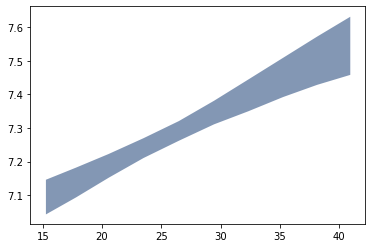

In [12]:
PlotConfidenceIntervals(ages, inters, slopes, percent=90)

In [13]:
class SlopeTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        ages, weights = data
        _, slope = thinkstats2.LeastSquares(ages, weights)
        return slope

    def MakeModel(self):
        _, weights = self.data
        self.ybar = weights.mean()
        self.res = weights - self.ybar

    def RunModel(self):
        ages, _ = self.data
        weights = self.ybar + np.random.permutation(self.res)
        return ages, weights

In [20]:
live, _, _ = first.MakeFrames()
live = live.dropna(subset=['agepreg','totalwgt_lb'])
ht = SlopeTest((live.agepreg, live.totalwgt_lb))
pvalue = ht.PValue()
print(f'p-value is: {pvalue:.2f}')

p-value is: 0.00


In [21]:
inters, slopes = SamplingDistribution(live, iters=1001)
slope_cdf = thinkstats2.Cdf(slopes)
pvalue = slope_cdf[0]
print(f'p-value is: {pvalue:.2f}')

p-value is: 0.00


In [28]:
def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

In [29]:
ResampleRowsWeighted(live)

,caseid,pregordr,howpreg_n,howpreg_p,moscurrp,nowprgdk,pregend1,pregend2,nbrnaliv,multbrth,...,laborfor_i,religion_i,metro_i,basewgt,adj_mod_basewgt,finalwgt,secu_p,sest,cmintvw,totalwgt_lb
2751,2421,5,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,15099.991503,28979.807361,52885.250453,2,23,NaN,5.8750
130,149,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,2335.452445,2543.714823,2856.591746,1,45,NaN,6.1250
2566,2263,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,5162.534414,7831.867098,13588.289415,2,78,NaN,8.5625
8846,8108,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,30500.514475,32668.491591,59616.730305,1,32,NaN,7.0625
8731,8012,4,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,4870.730991,9347.875845,16218.564591,1,70,NaN,5.5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,254,3,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,15775.557798,19296.796005,32158.110542,1,20,NaN,6.2500
2344,2085,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3363.350488,4033.859243,5119.370765,2,58,NaN,6.3750
5807,5322,1,NaN,NaN,NaN,NaN,5.0,NaN,1.0,NaN,...,0,0,0,4774.273121,5133.850106,8907.229933,2,59,NaN,8.0625
10089,9319,3,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,8074.439372,8741.671657,13263.738405,2,78,NaN,7.8125


In [38]:
iters = 101 
estimates = [thinkstats2.ResampleRowsWeighted(live).totalwgt_lb.mean() for _ in range(iters)]

In [39]:
estimates

[7.342463764107103,
 7.341855222394335,
 7.358431068820535,
 7.32386866563399,
 7.365353230803275,
 7.354848971011286,
 7.330977539278601,
 7.326911374197832,
 7.342339289665856,
 7.365166519141403,
 7.3579055100685995,
 7.341343494135871,
 7.344510677140961,
 7.353189311794645,
 7.353396769196725,
 7.343141458287231,
 7.353956904182342,
 7.349883823854835,
 7.340188647930958,
 7.360975879619385,
 7.350195009957956,
 7.3388055985837575,
 7.348618333702147,
 7.349572637751715,
 7.356066054436822,
 7.371424817437486,
 7.352857379951317,
 7.355989986722726,
 7.344987829165745,
 7.322444124806373,
 7.341142951980527,
 7.338646547908829,
 7.340555156007967,
 7.353548904624917,
 7.364295198052666,
 7.359226322195176,
 7.351349856162868,
 7.350540772294756,
 7.348175757911042,
 7.324172936490374,
 7.337401803496348,
 7.348521520247843,
 7.3675038725381725,
 7.336406007966365,
 7.322734565169285,
 7.337533193184333,
 7.373229696835583,
 7.340610477981854,
 7.353092498340341,
 7.336163974330604